# Prophet Baseline

*Anders Poirel 23-03-2020*


I'll be trying out `fbprophet` models with nearly-default parameters and all regressors used in previous notebooks to establish a baseline for further tuning

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os.path import join

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (cross_validate,
                                    TimeSeriesSplit)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [3]:
from sklearn.metrics import mean_absolute_error

In [4]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

In [5]:
sns.set()

## Pre-processing

I take some time to prototype a pre-processing function that we can us in the future. We keep `week_start_date` and drop other time-related features as this the date format `fbprophet` wants. furthermore, we drop some other features that have high correlation with others as determined in our exploration notebook

In [5]:
def data_preprocessing(path):
    features = pd.read_csv(path)
    features = features.drop(['year', 'weekofyear'],
                            axis = 1)
    features = features.drop(['reanalysis_sat_precip_amt_mm',
                              'reanalysis_tdtr_k'],
                            axis = 1)
    features = features.rename({'week_start_date': 'ds'}, axis = 1)
    features_sj = features[features['city'] == 'sj'].drop('city', axis = 1)
    features_iq = features[features['city'] == 'iq'].drop('city', axis = 1)
    return (features_sj, features_iq)

In [6]:
DATA_PATH = '../data/raw'

In [7]:
train_sj, train_iq = data_preprocessing(join(DATA_PATH,
    'dengue_features_train.csv'))
test_sj, test_iq = data_preprocessing(join(DATA_PATH,
    'dengue_features_test.csv'))

In [8]:
train_labels = pd.read_csv(join(DATA_PATH, 'dengue_labels_train.csv'))

## Models test

### San Juan

In [9]:
model_sj = Prophet(
    growth = 'linear',
    yearly_seasonality = True,
    weekly_seasonality = False,
    daily_seasonality = False
)
regressors = train_sj.columns.values[1:19]
for name in regressors:
    model_sj.add_regressor(name)

Normally I'd use a `Pipeline` for the full model, but I haven't figured out how to make a `Prophet` model play nice with the rest yet

In [10]:
numeric_features = train_sj.columns[1:]
main_data = ['y', 'ds']
numeric_transformer = Pipeline([
    ('impute', SimpleImputer(strategy = 'median')),
    ('scale', StandardScaler())
])
preprocessor = ColumnTransformer(
    transformers =  [
        ('num', numeric_transformer, numeric_features),
    ]
)

In [11]:
train_sj.loc[:, 'ndvi_ne': ] = preprocessor.fit_transform(train_sj)
train_sj['y'] = train_labels[train_labels['city'] == 'sj']['total_cases']
train_sj

,ds,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,y
0,1990-04-30,0.677476,0.402603,0.368467,0.210211,-0.516098,-1.291892,-1.264077,-1.724398,-1.275251,-1.087714,0.044880,-1.540840,-1.634097,-1.109774,0.171251,-1.290885,-1.733786,-0.367070,4
1,1990-05-07,1.172594,0.829945,-0.270343,-0.188754,-0.281812,-0.773495,-0.687518,-0.741770,-0.398223,-0.700102,-0.351153,-0.355440,-0.759640,-0.208232,-0.463395,0.053454,-0.267821,-0.620279,5
2,1990-05-14,-0.268273,1.172170,-0.361535,0.088097,-0.017791,-0.310764,-0.328639,0.206155,-0.717142,-0.002402,-0.121307,1.031757,0.189219,-0.208232,-0.326174,0.345701,0.131988,0.502054,4
3,1990-05-21,0.740630,1.973504,0.882571,1.260652,-0.449867,-0.143764,-0.040359,0.126705,0.000426,-0.234969,-0.464949,0.523668,0.076237,0.328641,0.016878,0.988646,0.465162,-0.777680,3
4,1990-05-28,1.447893,2.163928,1.300642,1.467143,-0.626482,0.287654,0.318519,0.453639,0.399075,0.152643,-0.512833,0.560051,0.421611,1.371999,3.138648,1.982287,0.864971,-0.716088,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,2008-03-25,0.209050,-1.193675,2.348723,2.348737,-0.183368,-1.790574,-1.911235,-1.928047,-1.354981,-2.250548,-0.643811,-1.279815,-1.871082,-1.393405,-1.166651,-0.940188,-1.000803,-0.852958,4
932,2008-04-01,-1.003623,-0.937307,-1.030448,-1.794998,-0.709834,-0.879030,-0.864015,-1.199295,-1.275251,-0.622580,-0.753101,-1.175320,-1.216158,-0.542512,0.068335,-0.589491,-0.267821,-0.897441,3
933,2008-04-08,-2.230428,-1.336492,-0.705339,-0.446030,-0.413823,-1.383511,-1.411158,-1.520750,-1.594170,-1.165236,0.129382,-1.048827,-1.523871,-1.423795,-1.252414,-1.290885,-0.600994,0.135927,1
934,2008-04-15,-0.587012,0.006382,0.464249,0.791167,-0.795889,-1.245503,-1.234661,-1.813894,-1.354981,-1.087714,-0.720708,-1.860669,-1.733300,-1.200941,-0.617768,-1.290885,-0.600994,-0.531314,3


In [12]:
model_sj.fit(train_sj)

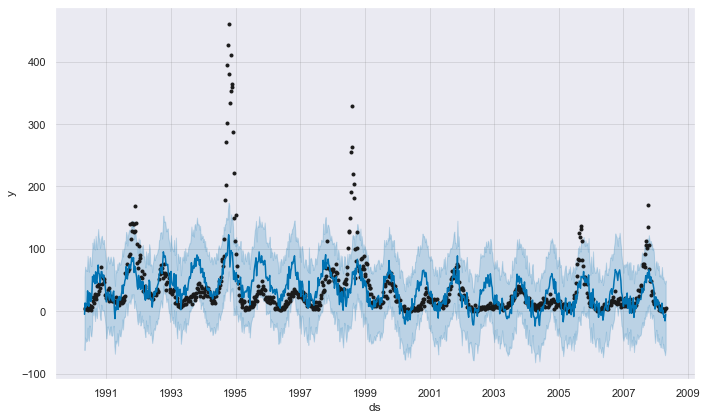

In [24]:
forecast_sj = model_sj.predict(train_sj)
fig = model_sj.plot(forecast_sj)

The model seems to be capturing the main components  of seasonality, but missing the large peaks in cases in 1994 and 1998

#### Cross-validation

In [14]:
cv_sj = cross_validation(model_sj, horizon = '730 days')

INFO:fbprophet:Making 10 forecasts with cutoffs between 1997-04-25 00:00:00 and 2006-04-23 00:00:00


In [15]:
cv_sj = cross_validation(model_sj, horizon = '730 days')

35.774925708958385

Which compare to our previous best of 32

### Iquitos

In [16]:
model_iq = Prophet(
    growth = 'linear',
    yearly_seasonality = True,
    weekly_seasonality = False,
    daily_seasonality = False
)
regressors = train_iq.columns.values[1:19]
for name in regressors:
    model_iq.add_regressor(name)

In [17]:
train_iq.loc[:, 'ndvi_ne': ] = preprocessor.fit_transform(train_iq)
train_iq['y'] = train_labels[train_labels['city'] == 'iq']['total_cases']

In [18]:
model_iq.fit(train_iq)

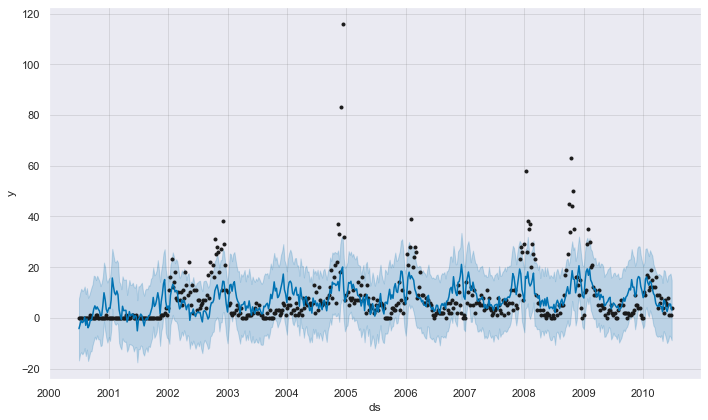

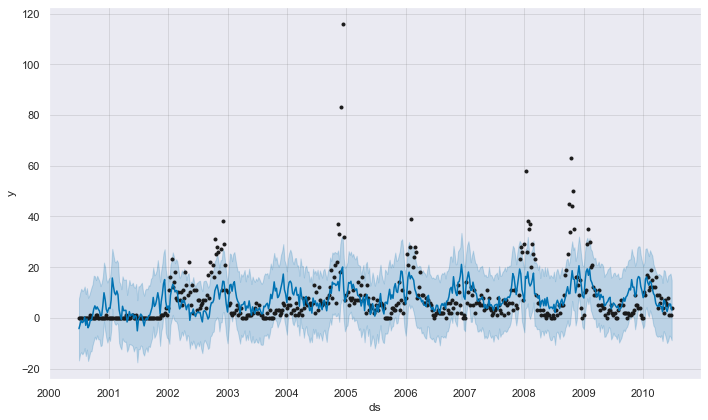

In [25]:
forecast_iq = model_iq.predict(train_iq)
model_iq.plot(forecast_iq)

The seasonal components seem to be more complex than they should

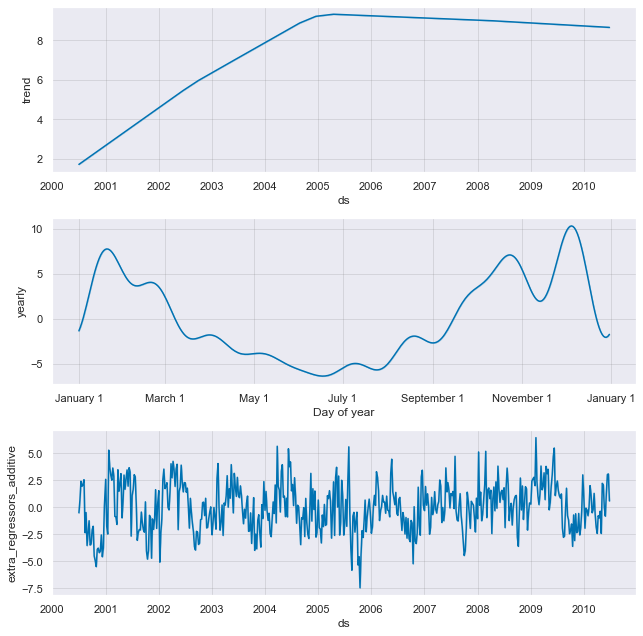

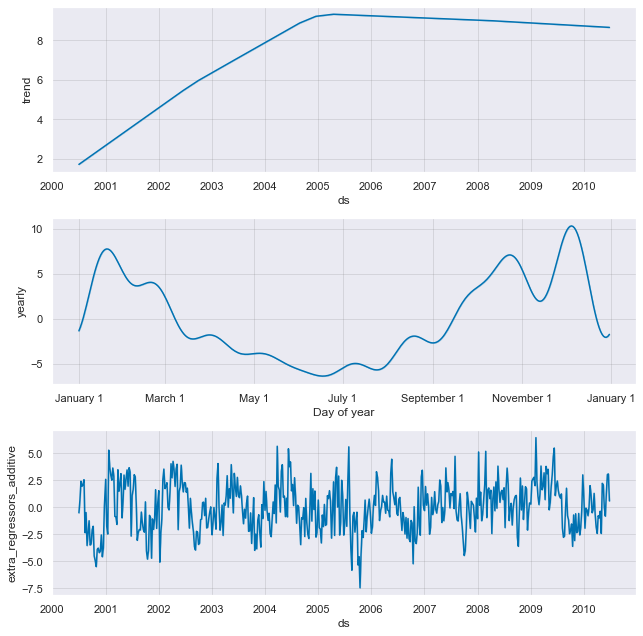

In [26]:
model_iq.plot_components(forecast_iq)

#### Cross-validation

In [21]:
cv_iq = cross_validation(model_iq, horizon = '730 days')

INFO:fbprophet:Making 2 forecasts with cutoffs between 2007-06-26 00:00:00 and 2008-06-25 00:00:00


In [22]:
mean_absolute_error(cv_iq['yhat'], cv_iq['y'])

7.744620745815824

Once again, a bit worse than our previous best of 
~ 7.7

## Discussion

Prophet on this first iteration did not yield 
any improvement. That being said, this baseline is not too far
off from our best results